In [14]:
import random
from typing import Tuple
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import import_ipynb
from data_loader import Batch

In [15]:
class Preprocessor:
    def __init__(self,
                 img_size: Tuple[int, int],
                 padding: int = 0,
                 dynamic_width: bool = False,
                 data_augmentation: bool = False,
                 line_mode: bool = False) -> None:
        
        assert not(dynamic_width and data_augmentation)
        assert not(padding >0 and not dynamic_width)

        self.img_size = img_size
        self.padding = padding
        self.dynamic_width = dynamic_width
        self.data_augmentation = data_augmentation
        self.line_mode = line_mode

    @staticmethod
    def _truncate_label(text:str, max_text_len: int) -> str:
        cost = 0
        for i in range(len(text)):
            if i != 0 and text[i] == text[i - 1]:
                cost += 2
            else:
                cost += 1
            if cost > max_text_len:
                return text[:i]
        return text

    def _simulate_text_line(self, batch: Batch) -> Batch:
        """Create image of a text line by pasting multiple word images into an image."""

        default_word_sep = 30
        default_num_words = 5

        # go over all batch elements
        res_imgs = []
        res_gt_texts = []
        for i in range(batch.batch_size):
            # number of words to put into current line
            num_words = random.randint(1, 8) if self.data_augmentation else default_num_words

            # concat ground truth texts
            curr_gt = ' '.join([batch.gt_texts[(i + j) % batch.batch_size] for j in range(num_words)])
            res_gt_texts.append(curr_gt)

            # put selected word images into list, compute target image size
            sel_imgs = []
            word_seps = [0]
            h = 0
            w = 0
            for j in range(num_words):
                curr_sel_img = batch.imgs[(i + j) % batch.batch_size]
                curr_word_sep = random.randint(20, 50) if self.data_augmentation else default_word_sep
                h = max(h, curr_sel_img.shape[0])
                w += curr_sel_img.shape[1]
                sel_imgs.append(curr_sel_img)
                if j + 1 < num_words:
                    w += curr_word_sep
                    word_seps.append(curr_word_sep)

            # put all selected word images into target image
            target = np.ones([h, w], np.uint8) * 255
            x = 0
            for curr_sel_img, curr_word_sep in zip(sel_imgs, word_seps):
                x += curr_word_sep
                y = (h - curr_sel_img.shape[0]) // 2
                target[y:y + curr_sel_img.shape[0]:, x:x + curr_sel_img.shape[1]] = curr_sel_img
                x += curr_sel_img.shape[1]

            # put image of line into result
            res_imgs.append(target)

        return Batch(res_imgs, res_gt_texts, batch.batch_size)

    def process_img(self, img: np.ndarray) -> np.ndarray:
        """Resize to target size, apply data augmentation."""

        # there are damaged files in IAM dataset - just use black image instead
        if img is None:
            img = np.zeros(self.img_size[::-1])

        # data augmentation
        img = img.astype(float)
        if self.data_augmentation:
            # photometric data augmentation
            if random.random() < 0.25:
                def rand_odd():
                    return random.randint(1, 3) * 2 + 1
                img = cv2.GaussianBlur(img, (rand_odd(), rand_odd()), 0)
            if random.random() < 0.25:
                img = cv2.dilate(img, np.ones((3, 3)))
            if random.random() < 0.25:
                img = cv2.erode(img, np.ones((3, 3)))

            # geometric data augmentation
            wt, ht = self.img_size
            h, w = img.shape
            f = min(wt / w, ht / h)
            fx = f * np.random.uniform(0.75, 1.05)
            fy = f * np.random.uniform(0.75, 1.05)

            # random position around center
            txc = (wt - w * fx) / 2
            tyc = (ht - h * fy) / 2
            freedom_x = max((wt - fx * w) / 2, 0)
            freedom_y = max((ht - fy * h) / 2, 0)
            tx = txc + np.random.uniform(-freedom_x, freedom_x)
            ty = tyc + np.random.uniform(-freedom_y, freedom_y)

            # map image into target image
            M = np.float32([[fx, 0, tx], [0, fy, ty]])
            target = np.ones(self.img_size[::-1]) * 255
            img = cv2.warpAffine(img, M, dsize=self.img_size, dst=target, borderMode=cv2.BORDER_TRANSPARENT)

            # photometric data augmentation
            if random.random() < 0.5:
                img = img * (0.25 + random.random() * 0.75)
            if random.random() < 0.25:
                img = np.clip(img + (np.random.random(img.shape) - 0.5) * random.randint(1, 25), 0, 255)
            if random.random() < 0.1:
                img = 255 - img

        # no data augmentation
        else:
            if self.dynamic_width:
                ht = self.img_size[1]
                h, w = img.shape
                f = ht / h
                wt = int(f * w + self.padding)
                wt = wt + (4 - wt) % 4
                tx = (wt - w * f) / 2
                ty = 0
            else:
                wt, ht = self.img_size
                h, w = img.shape
                f = min(wt / w, ht / h)
                tx = (wt - w * f) / 2
                ty = (ht - h * f) / 2

            # map image into target image
            M = np.float32([[f, 0, tx], [0, f, ty]])
            target = np.ones([ht, wt]) * 255
            img = cv2.warpAffine(img, M, dsize=(wt, ht), dst=target, borderMode=cv2.BORDER_TRANSPARENT)

        # transpose for TF
        img = cv2.transpose(img)

        # convert to range [-1, 1]
        img = img / 255 - 0.5
        return img

    def process_batch(self, batch: Batch) -> Batch:
        if self.line_mode:
            batch = self._simulate_text_line(batch)

        res_imgs = [self.process_img(img) for img in batch.imgs]
        max_text_len = res_imgs[0].shape[0] // 4
        res_gt_texts = [self._truncate_label(gt_text, max_text_len) for gt_text in batch.gt_texts]
        return Batch(res_imgs, res_gt_texts, batch.batch_size)




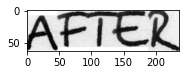

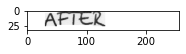

In [19]:

def main():
    import matplotlib.pyplot as plt

    img = cv2.imread('../data/test.png', cv2.IMREAD_GRAYSCALE)
    img_aug = Preprocessor((256, 32), data_augmentation=True).process_img(img)
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.subplot(122)
    plt.imshow(cv2.transpose(img_aug) + 0.5, cmap='gray', vmin=0, vmax=1)
    plt.show()


if __name__ == '__main__':
    main()